# Diffusion Network to generate 1d functions with some probability distribution

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- Config ---
n_points = 50
n_classes = 3
n_steps = 200
batch_size = 10
noise_std = 0.2

# --- Generate 5 shifted sine curves ---
def generate_shifted_sine_batch(n_shifts=5, n_points=100):
    phases = torch.arange(n_shifts) * (2 * torch.pi / n_shifts)
    x = torch.linspace(0, 2 * torch.pi, n_points)
    sines = torch.stack([torch.sin(x + shift) for shift in phases])  # [5, n_points]
    return x, sines

# --- Denoising model with class conditioning ---
class DenoiseMLP(nn.Module):
    def __init__(self, n_points, n_classes):
        super().__init__()
        input_dim = n_points + n_classes
        hidden_dim = 50

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_points)
        )

    def forward(self, x_input_with_label):
        return self.net(x_input_with_label)  # Only func_out

# --- Noise step function ---
def add_noise_step(x, noise_level):
    return x + noise_level * torch.randn_like(x)

# --- Training loop ---
x_grid, sine_set = generate_shifted_sine_batch(n_shifts=n_classes, n_points=n_points)
model = DenoiseMLP(n_points, n_classes)
optimizer = optim.Adam(model.parameters(), lr=0.002)
mse_loss = nn.MSELoss()

for epoch in range(401):
    allowed_classes = range(0,n_classes)
    idx = torch.tensor(
        [allowed_classes[torch.randint(0, len(allowed_classes), ())] for _ in range(batch_size)],
        dtype=torch.long
    )

    x_clean = sine_set[idx]  # [B, n_points]

    # Create one-hot class labels (input only)
    labels = torch.nn.functional.one_hot(idx, num_classes=n_classes).float()  # [B, 5]

    # Generate noisy trajectory
    x_t = x_clean.clone()
    trajectory = [x_t.clone()]
    for _ in range(n_steps):
        x_t = add_noise_step(x_t, noise_std / n_steps)
        trajectory.append(x_t.clone())

    # Reverse denoising step-by-step
    loss = 0.0
    for step in reversed(range(1, n_steps + 1)):
        x_input = trajectory[step]
        x_target = trajectory[step - 1]

        # Concatenate input with class condition
        x_input_with_label = torch.cat([x_input, labels], dim=1)
        x_pred = model(x_input_with_label)  # Only function output

        # 1. Denoising loss
        loss_denoise = mse_loss(x_pred, x_target)

        # 2. Pull toward the correct target function (via label)
        target_template = labels @ sine_set  # [B, n_points]
        loss_template = mse_loss(x_pred, target_template)

        cos = nn.CosineSimilarity(dim=1)
        loss_cos = 1 - cos(x_pred, target_template).mean()

        # 3. Final step: optionally pull toward clean function
        loss_align = mse_loss(x_pred, x_clean) if step == 1 else 0.0

        # Combine
        loss += loss_denoise + 2 * loss_template + 0.2 * loss_cos

    loss /= n_steps
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")


Epoch 0: Loss = 1.773515
Epoch 100: Loss = 0.000191
Epoch 200: Loss = 0.000098
Epoch 300: Loss = 0.000102
Epoch 400: Loss = 0.000112


## Make sampling a function

In [2]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_and_match(model, class_idx, sine_set, x_grid,
                     n_steps=10, n_points=50, n_classes=3, noise_std=noise_std, amplify=1.01):
    """
    Generate one sample from noise, conditioned on a given class label,
    and compare to the training sine functions.

    Returns:
        final: generated function (1D tensor)
        closest: index of closest sine function (0–n_classes-1)
        mse: mean squared error to closest function
    """
    x = noise_std * torch.randn(1, n_points)
    label = torch.nn.functional.one_hot(torch.tensor([class_idx]), num_classes=n_classes).float()  # shape [1, n_classes]

    for _ in range(n_steps):
        x_input = torch.cat([x, label], dim=1)  # shape [1, n_points + n_classes]
        x = amplify * model(x_input)  # denoising step

    final = x.squeeze()

    # Compute MSE to each sine and pick the closest
    distances = torch.stack([torch.mean((final - s)**2) for s in sine_set])
    closest = torch.argmin(distances).item()

    return final, closest, distances[closest].item()


## Plot Results

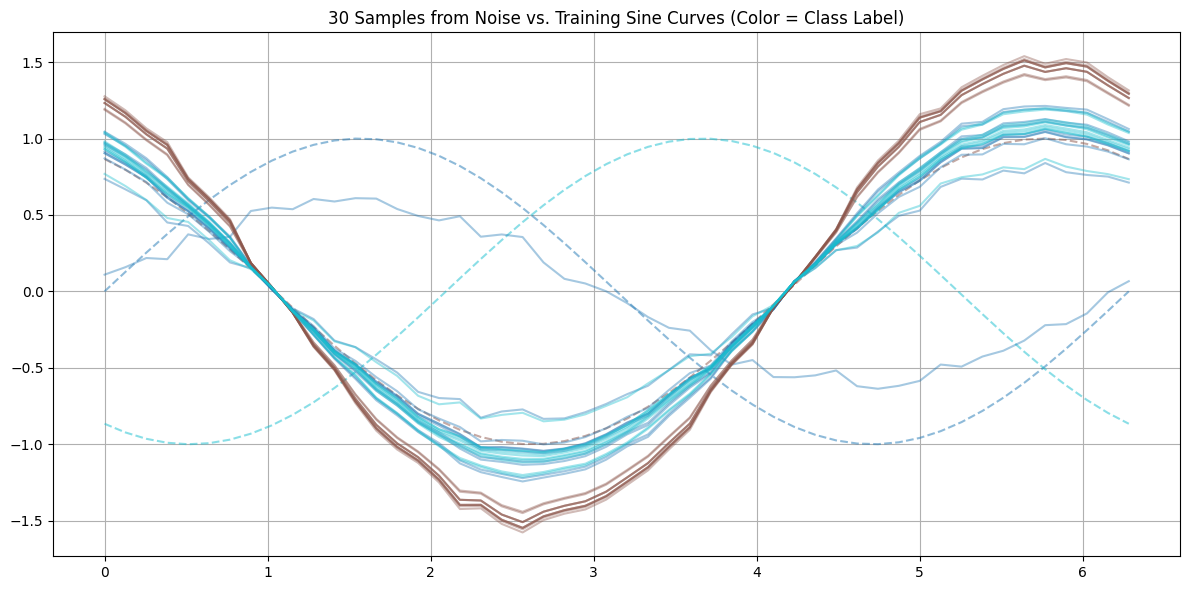

Match frequencies (correctly reconstructed per class):
  Sine 1: 1/10 (10.0%)
  Sine 2: 10/10 (100.0%)
  Sine 3: 0/10 (0.0%)


In [3]:
import matplotlib.pyplot as plt
import collections
import matplotlib.cm as cm
import numpy as np

n_trials = 10  # per class
results = []
samples = []

# Loop over all n_classes
for class_idx in range(n_classes):
    for _ in range(n_trials):
        final, closest, mse = sample_and_match(
            model, class_idx, sine_set, x_grid,
            n_classes=n_classes, amplify=1.15 
        )
        results.append((class_idx, closest, mse))  # store true class, closest match, mse
        samples.append((class_idx, final))

# --- Plot all samples with training sine curves ---
plt.figure(figsize=(12, 6))

# Create a color map for any number of classes
cmap = plt.get_cmap("tab10", n_classes)
colors = [cmap(i) for i in range(n_classes)]

# Plot reference sine curves
for i in range(sine_set.size(0)):
    plt.plot(x_grid, sine_set[i], color=colors[i], linestyle='--', alpha=0.5)

# Plot generated samples
for class_idx, sample in samples:
    plt.plot(x_grid, sample, color=colors[class_idx], alpha=0.4)

plt.title(f"{n_trials * n_classes} Samples from Noise vs. Training Sine Curves (Color = Class Label)")
plt.grid(True)
plt.tight_layout()
plt.savefig("samples_vs_sines_conditioned.png", dpi=150, bbox_inches='tight')
plt.show()

# --- Count correct matches ---
correct_shape = collections.Counter()
total_by_class = collections.Counter()

for true_label, matched, _ in results:
    total_by_class[true_label] += 1
    if true_label == matched:
        correct_shape[true_label] += 1

# --- Print stats
eps = 1e-5
print("Match frequencies (correctly reconstructed per class):")
for idx in range(n_classes):
    total = total_by_class[idx]
    correct = correct_shape[idx]
    print(f"  Sine {idx+1}: {correct}/{total} ({100 * correct / (total + eps):.1f}%)")


In [4]:
import numpy as np

conf_matrix = np.zeros((n_classes, n_classes), dtype=int)
for true_label, closest, _ in results:
    conf_matrix[true_label][closest] += 1

print("\nConfusion matrix (rows = true class, cols = closest matched sine):")
print(conf_matrix)



Confusion matrix (rows = true class, cols = closest matched sine):
[[ 1  9  0]
 [ 0 10  0]
 [ 0 10  0]]


In [5]:
match_count = sum(1 for true, closest, _ in results if closest == true)
print(f"\nCorrect shape match in {match_count}/{len(results)} cases "
      f"({100 * match_count / len(results):.1f}%)")



Correct shape match in 11/30 cases (36.7%)


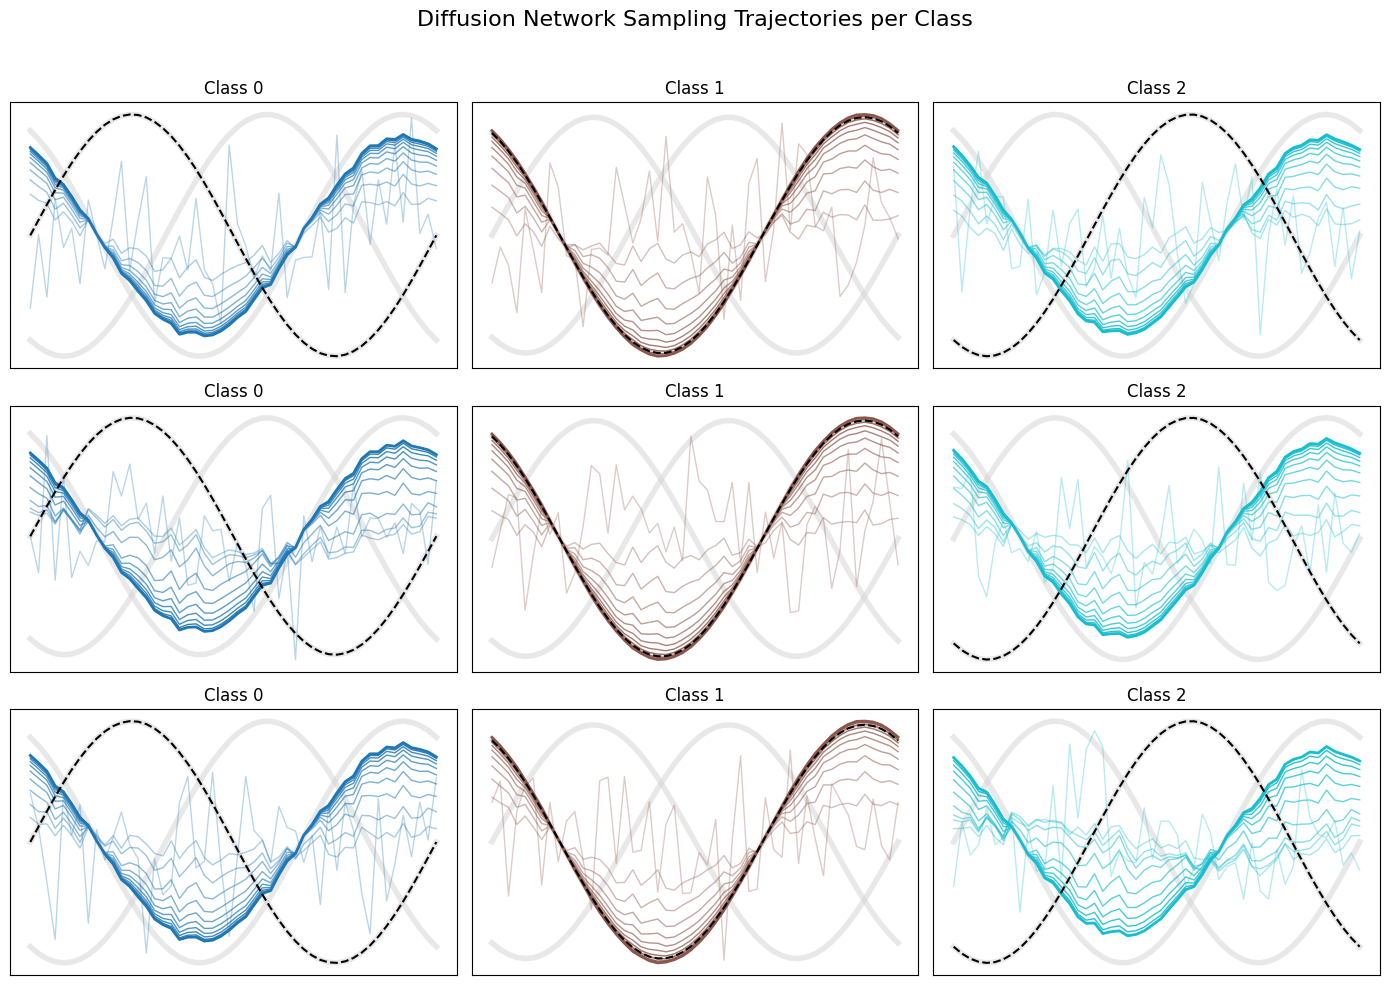

In [6]:
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def generate_trajectory(model, class_idx, sine_set, x_grid, n_steps=30, n_classes=3, n_points=50, noise_std=0.4, amplify=1.01):
    """
    Generate a denoising trajectory from noise for a given class.
    Returns a list of [x_0, ..., x_T] including intermediate steps and final.
    """
    x = noise_std * torch.randn(1, n_points)
    label = torch.nn.functional.one_hot(torch.tensor([class_idx]), num_classes=n_classes).float()
    trajectory = [x.squeeze().numpy()]
    for _ in range(n_steps):
        x_input = torch.cat([x, label], dim=1)
        x = amplify * model(x_input)
        trajectory.append(x.squeeze().numpy())
    return trajectory

# --- Config ---
n_rows, n_cols = 3, 3
steps_to_show = 20
d_show = 2  # <--- only show every d_show-th step
total_plots = n_rows * n_cols

plt.figure(figsize=(14, 10))
cmap = plt.get_cmap("tab10", n_classes)
colors = [cmap(i) for i in range(n_classes)]

for plot_idx in range(total_plots):
    class_idx = plot_idx % n_classes
    traj = generate_trajectory(model, class_idx, sine_set, x_grid, n_steps=steps_to_show, n_classes=n_classes, n_points=n_points)

    plt.subplot(n_rows, n_cols, plot_idx + 1)

    # Plot all target sine curves in light gray
    for s in sine_set:
        plt.plot(x_grid, s, color='lightgray', linewidth=4, alpha=0.5)

    # Plot selected steps of the trajectory
    for i in range(0, len(traj), d_show):
        alpha = 0.3 + 0.7 * (i / steps_to_show)
        plt.plot(x_grid, traj[i], color=colors[class_idx], alpha=alpha, linewidth=2 if i == len(traj) - 1 else 1)

    # Overlay true target as dashed line
    plt.plot(x_grid, sine_set[class_idx], linestyle='--', color='black', linewidth=1.5)
    plt.title(f"Class {class_idx}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)

plt.suptitle("Diffusion Network Sampling Trajectories per Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("diffusion_network_sampling.png", dpi=150)
plt.show()
